### Sensitivity

In [1]:
import importlib
plots = importlib.import_module('plots')
importlib.reload(plots)
from plots import *

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

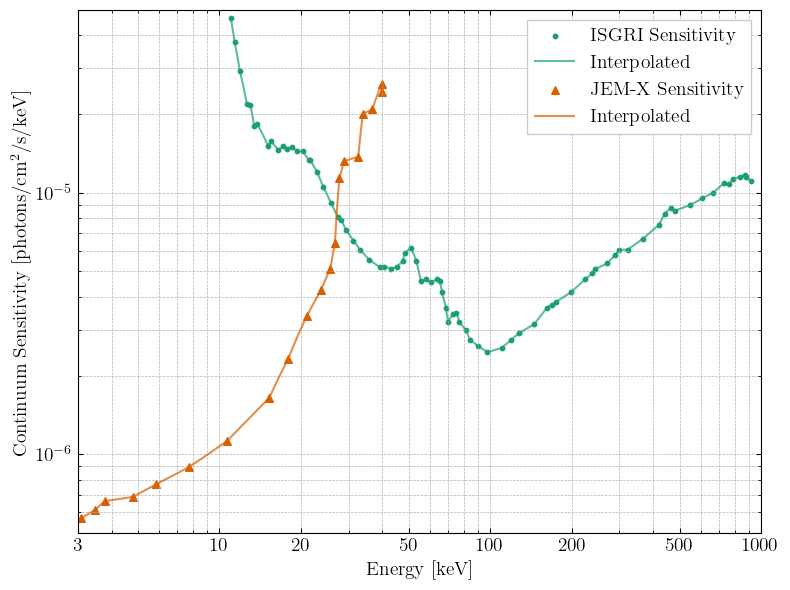

In [2]:
interp_funcs = plot_sensitivity(save=True)
isgri_interp = interp_funcs["ISGRI Sensitivity"]
jemx_interp = interp_funcs["JEM-X Sensitivity"]

In [3]:
isgri_sensitivity_upper_limits = sensitivity(isgri_interp)
jemx_sensitivity_upper_limits = sensitivity(jemx_interp, E_ranges=[(3,15)], observation_times=[297000])

Integrated sensitivity from 15 to 30 keV for a 77 ks observation time: 1.769e-04 +- 1.267e-08 photons/cm²/s
Integrated sensitivity from 30 to 60 keV for a 77 ks observation time: 1.634e-04 +- 1.455e-08 photons/cm²/s

Scaled sensitivity for 1284 ks observation time: 4.331e-05 +- 3.102e-09 photons/cm²/s
Scaled sensitivity for 2315 ks observation time: 2.981e-05 +- 2.653e-09 photons/cm²/s
Integrated sensitivity from 3 to 15 keV for a 77 ks observation time: 1.238e-05 +- 7.799e-09 photons/cm²/s

Scaled sensitivity for 297 ks observation time: 6.306e-06 +- 3.971e-09 photons/cm²/s


### Digitized spectra

In [101]:
import importlib
plots = importlib.import_module('plots')
importlib.reload(plots)
from plots import *

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

In [5]:
# 15 - 30 keV
upper_limit_stack = 1.767e-04/15 # divide by bandwidth
upper_limit_max =  2.910e-02/15
upper_limit_avg =  1.099e-04/15
upper_limit_sens = isgri_sensitivity_upper_limits[0]/15
upper_limits1 = ([15, 30], upper_limit_avg, r"ISGRI 15 - 30 keV")

# 30 - 60 keV
upper_limit_stack2 =  4.448e-05/30
upper_limit_max2 =  7.593e-03/30
upper_limit_avg2 =  8.552e-05/30
upper_limit_sens2 = isgri_sensitivity_upper_limits[1]/30
upper_limits2 = ([30, 60], upper_limit_avg2, r"ISGRI 30 - 60 keV")

# 3 - 15 keV
upper_limit_stack3 = 2.405e-03/12
upper_limit_max3 =  2.472e-02/12
upper_limit_avg3 = 2.094e-04/12
upper_limit_sens3 = jemx_sensitivity_upper_limits[0]/12
upper_limits3 = ([3, 15], upper_limit_avg3, r"JEM-X 3 - 15 keV")

# Upper limits list
upper_limits = [upper_limits1, upper_limits2, upper_limits3]

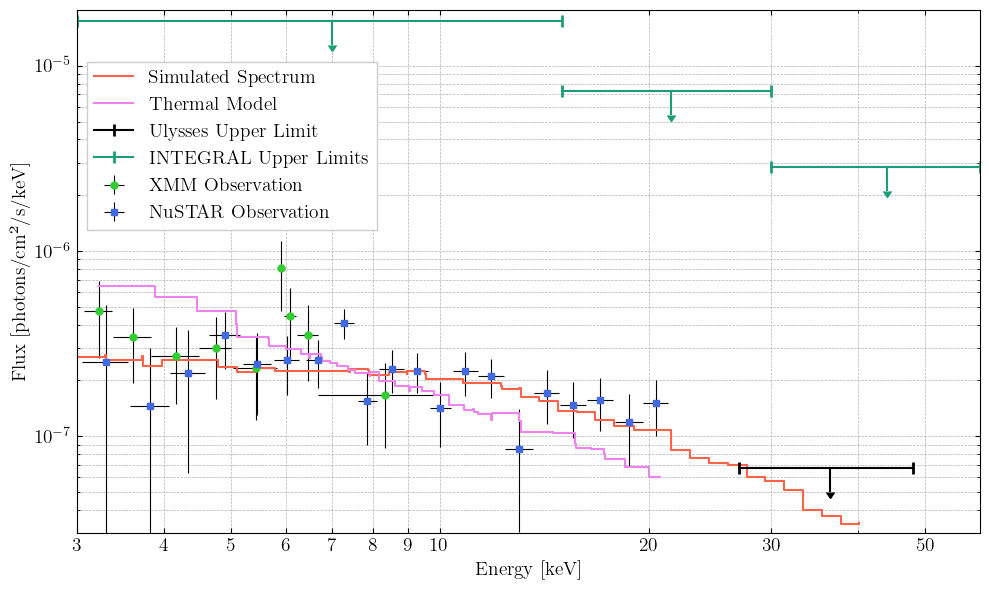

In [102]:
plot_upper_limits('../data/digitized-spectra.csv', upper_limits=upper_limits, save=True, save_name='upper_limits_spectrum')

### Ulysses paper

In [144]:
import importlib
plots = importlib.import_module('plots')
importlib.reload(plots)
from plots import *

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

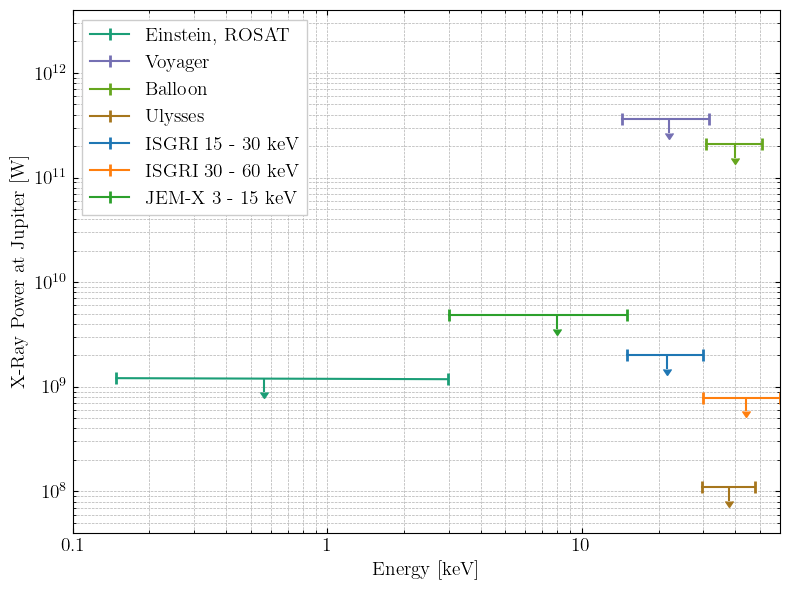

In [145]:
plot_upper_limits_ulysses('../data/digitized-upperlimits.csv', upper_limits=upper_limits, save=True, save_name='upper_limits_ulysses')